In [1]:
import pandas as pd
!pip install pykalman
!pip install scikit
!pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement scikit (from versions: none)
ERROR: No matching distribution found for scikit


In [2]:
df = pd.read_csv("/content/drive/MyDrive/p300/full_dataset.csv")

In [3]:
df.head()

Unnamed: 0  participant_id  timestep  channel_1  channel_2  channel_3  \
0           0               1         1  11.564022   6.806195  -0.839958   
1           1               1         2  11.496354   4.750291   0.263784   
2           2               1         3  11.021716   1.988979   1.273208   
3           3               1         4  10.592941  -1.048433   1.788976   
4           4               1         5  10.075521  -4.130195   1.296407   

   channel_4  channel_5  channel_6  channel_7  channel_8  trigger  
0   9.335871   5.796990  36.272963   5.265542   4.032394        0  
1   9.484304   5.252266  33.884664   4.147289   3.818456        0  
2   9.215325   4.437914  30.810695   3.426729   3.917395        0  
3   8.848998   3.339090  27.122807   2.947671   4.145565        0  
4   8.589282   1.947523  22.976416   2.374365   4.096638        0

In [4]:
print(df["trigger"].value_counts()[0])
print(df["trigger"].value_counts()[-1]) # time user was not paying attention to the target
print(df["trigger"].value_counts()[1]) # time user was paying attention to the target

298269
5250
750


In [5]:
df.describe()

Unnamed: 0  participant_id       timestep      channel_1  \
count  304269.000000   304269.000000  304269.000000  304269.000000   
mean    30426.429544        2.999816   30427.429544       0.025650   
std     17567.058960        1.414162   17567.058960      14.717844   
min         0.000000        1.000000       1.000000    -270.074453   
25%     15213.000000        2.000000   15214.000000      -6.224164   
50%     30426.000000        3.000000   30427.000000       0.077773   
75%     45640.000000        4.000000   45641.000000       6.445233   
max     60954.000000        5.000000   60955.000000     200.905095   

           channel_2      channel_3      channel_4      channel_5  \
count  304269.000000  304269.000000  304269.000000  304269.000000   
mean        0.016620       0.016952       0.017196       0.017680   
std        14.785876      16.062947      16.533646      13.344373   
min      -281.954395    -239.648731    -274.976030    -274.896928   
25%        -6.260286      -8.182673      -6.540344      -5.757506   
50%         0.007636      -0.028335      -0.045530       0.050592   
75%         6.434775       8.390611       6.457579       5.940146   
max       210.782720     207.103306     198.723082     213.409810   

           channel_6      channel_7      channel_8        trigger  
count  304269.000000  304269.000000  304269.000000  304269.000000  
mean        0.093182       0.022326       0.017643      -0.014790  
std        22.296148      14.522325      12.710763       0.139645  
min      -560.267373   -1084.562049    -261.998908      -1.000000  
25%        -6.379561      -5.356642      -4.800015       0.000000  
50%         0.094041       0.095163       0.076464       0.000000  
75%         6.588221       5.574729       4.922020       0.000000  
max       464.175084     203.588069     227.450226       1.000000

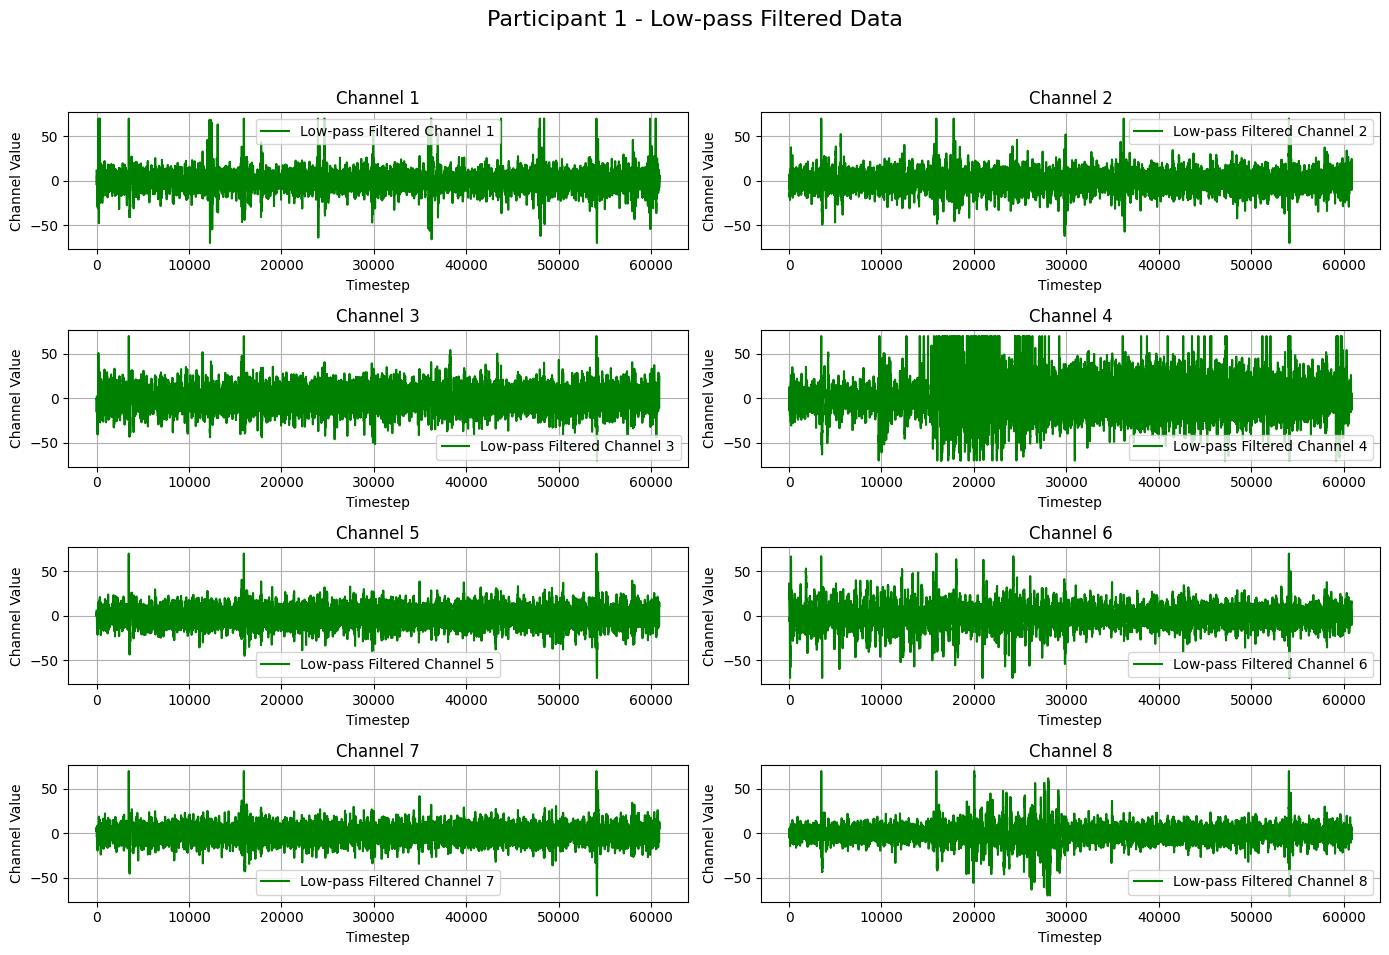

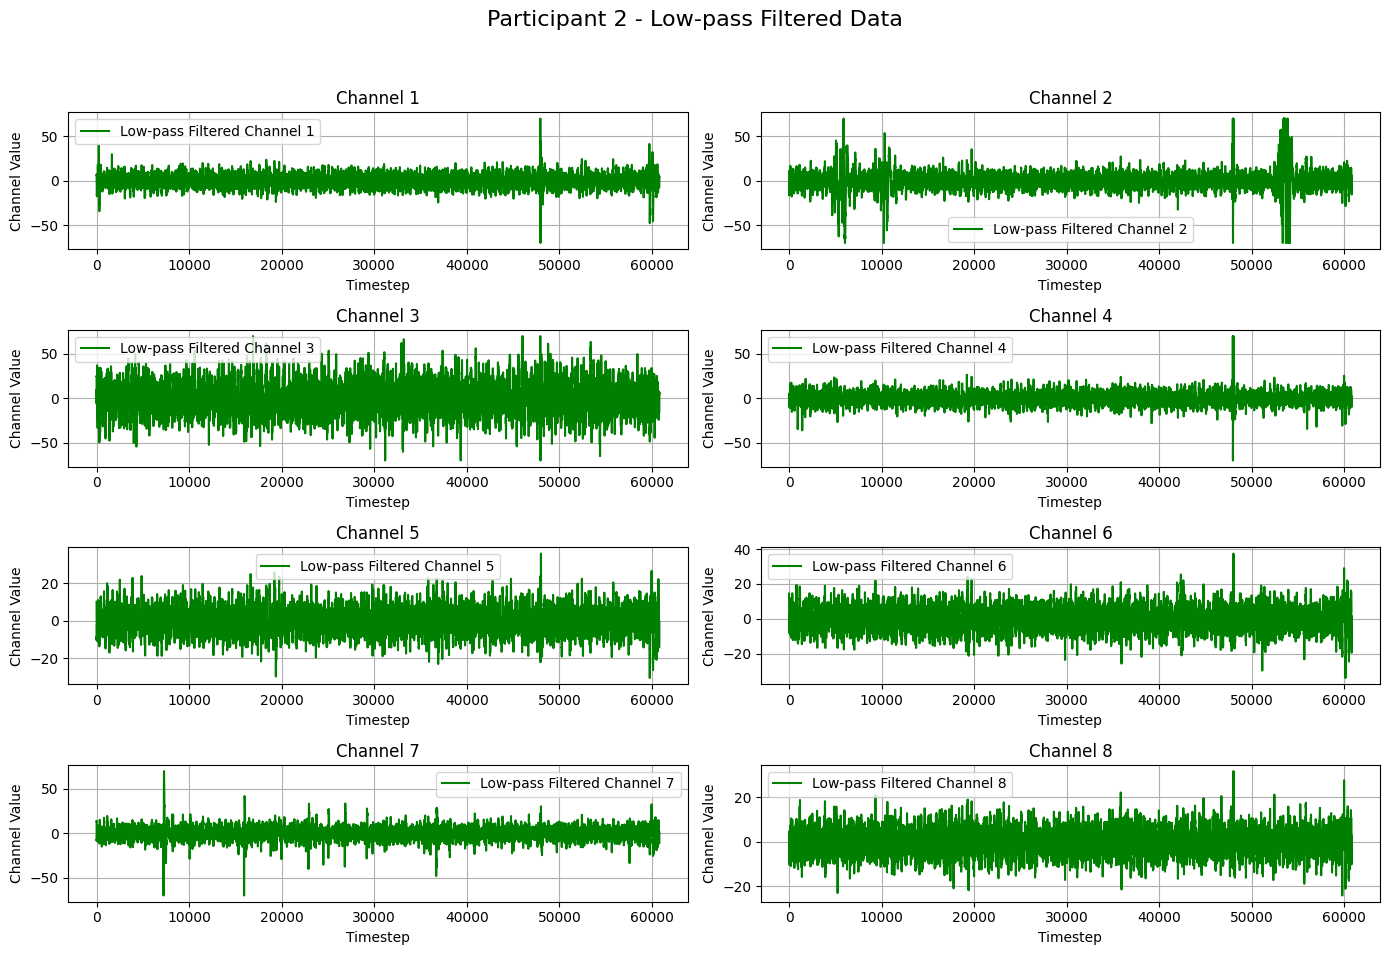

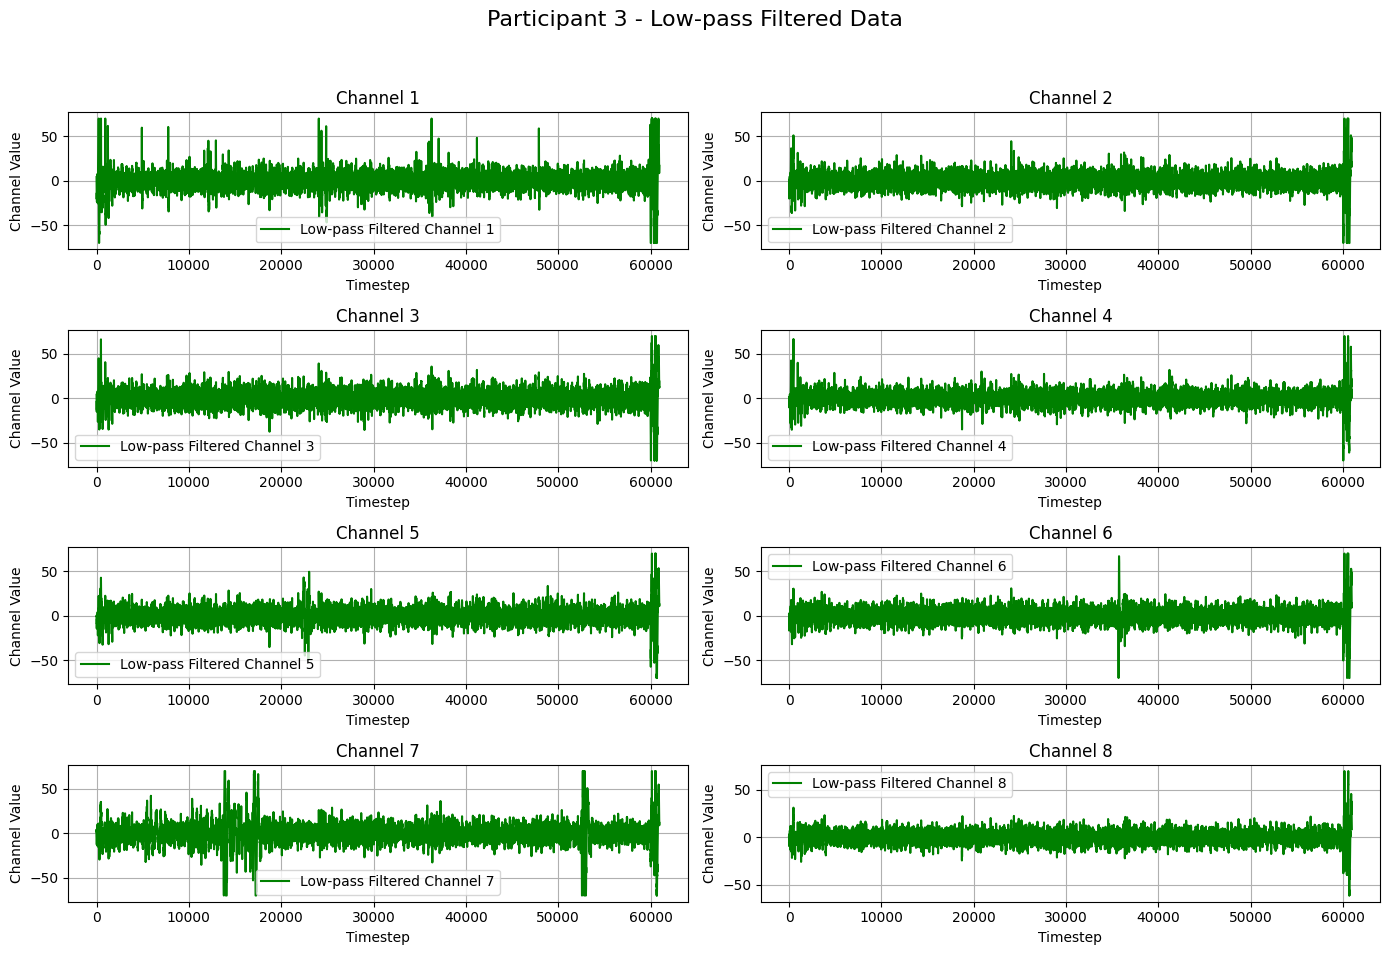

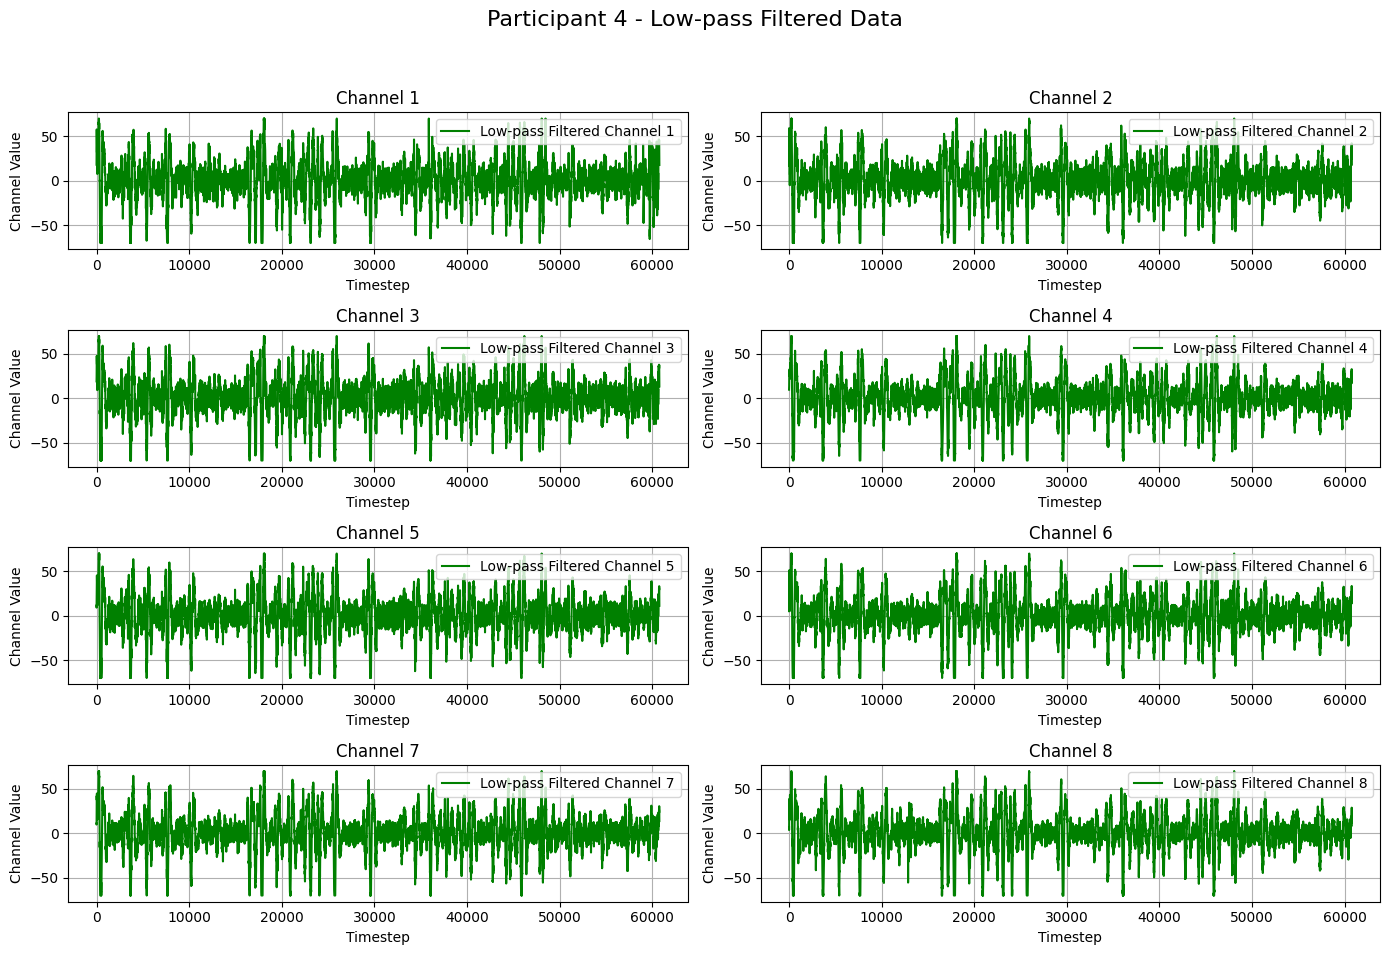

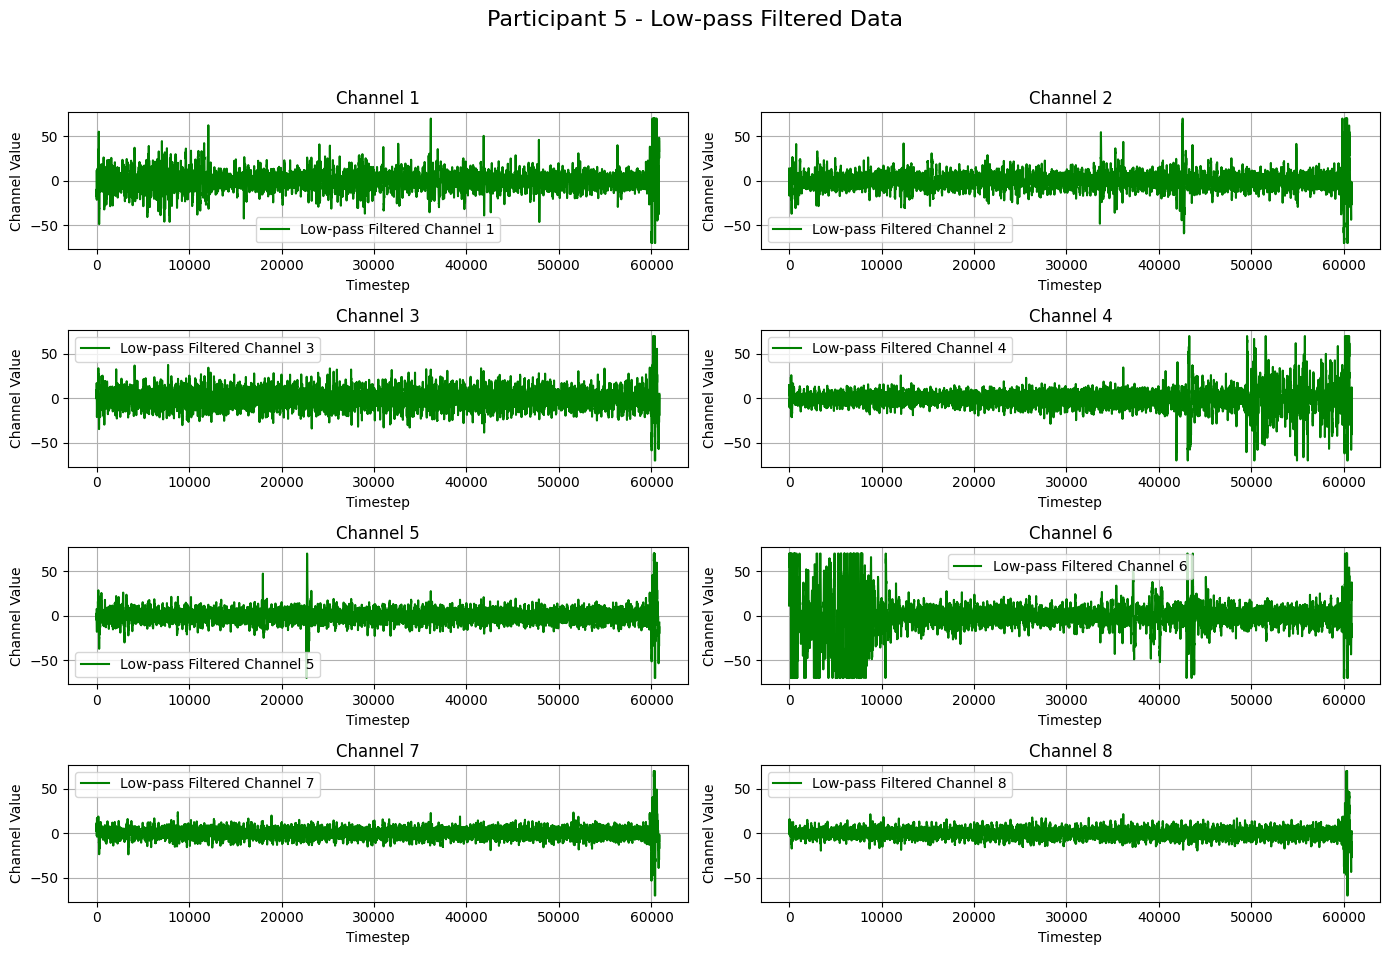

In [18]:
from scipy.signal import butter, filtfilt
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define the low-pass filter function using a Butterworth filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    if normal_cutoff <= 0 or normal_cutoff >= 1:
        raise ValueError(f"Cutoff frequency must be between 0 and {fs/2}.")
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Step 2: Apply the low-pass filter to a signal
def apply_lowpass_filter(data, cutoff=70, fs=1000, order=2):
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data)
    return y

# Step 3: Apply the low-pass filter only to values within [-70, 70]
def conditional_lowpass(data, lower_bound=-70, upper_bound=70):
    filtered_data = data.copy()
    mask = (data >= lower_bound) & (data <= upper_bound)
    filtered_data[mask] = apply_lowpass_filter(data[mask])

    # Clip the data to ensure it stays within the desired bounds
    filtered_data = filtered_data.clip(lower_bound, upper_bound)

    return filtered_data

# Assume df is your pandas DataFrame containing the data
df_filtered = df.copy()
for i in range(1, 9):  # Assuming channels 1 to 8
    df_filtered[f'channel_{i}'] = conditional_lowpass(df[f'channel_{i}'])

# Step 4: Plotting - Low-pass Filtered Data Only
grouped_lowpass = df_filtered.groupby('participant_id')

# Iterate through each participant's data
for participant_id, lowpass_group in grouped_lowpass:
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))  # 4 rows and 2 columns for 8 channels
    fig.suptitle(f'Participant {participant_id} - Low-pass Filtered Data', fontsize=16)

    # Plot each channel in a separate subplot
    for i in range(1, 9):
        ax = axs[(i-1)//2, (i-1)%2]  # Position in the 4x2 grid

        # Low-pass filtered data in green
        ax.plot(lowpass_group['timestep'], lowpass_group[f'channel_{i}'], label=f'Low-pass Filtered Channel {i}', color='green')

        ax.set_title(f'Channel {i}')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Channel Value')
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for the title
    plt.show()


In [8]:
import numpy as np

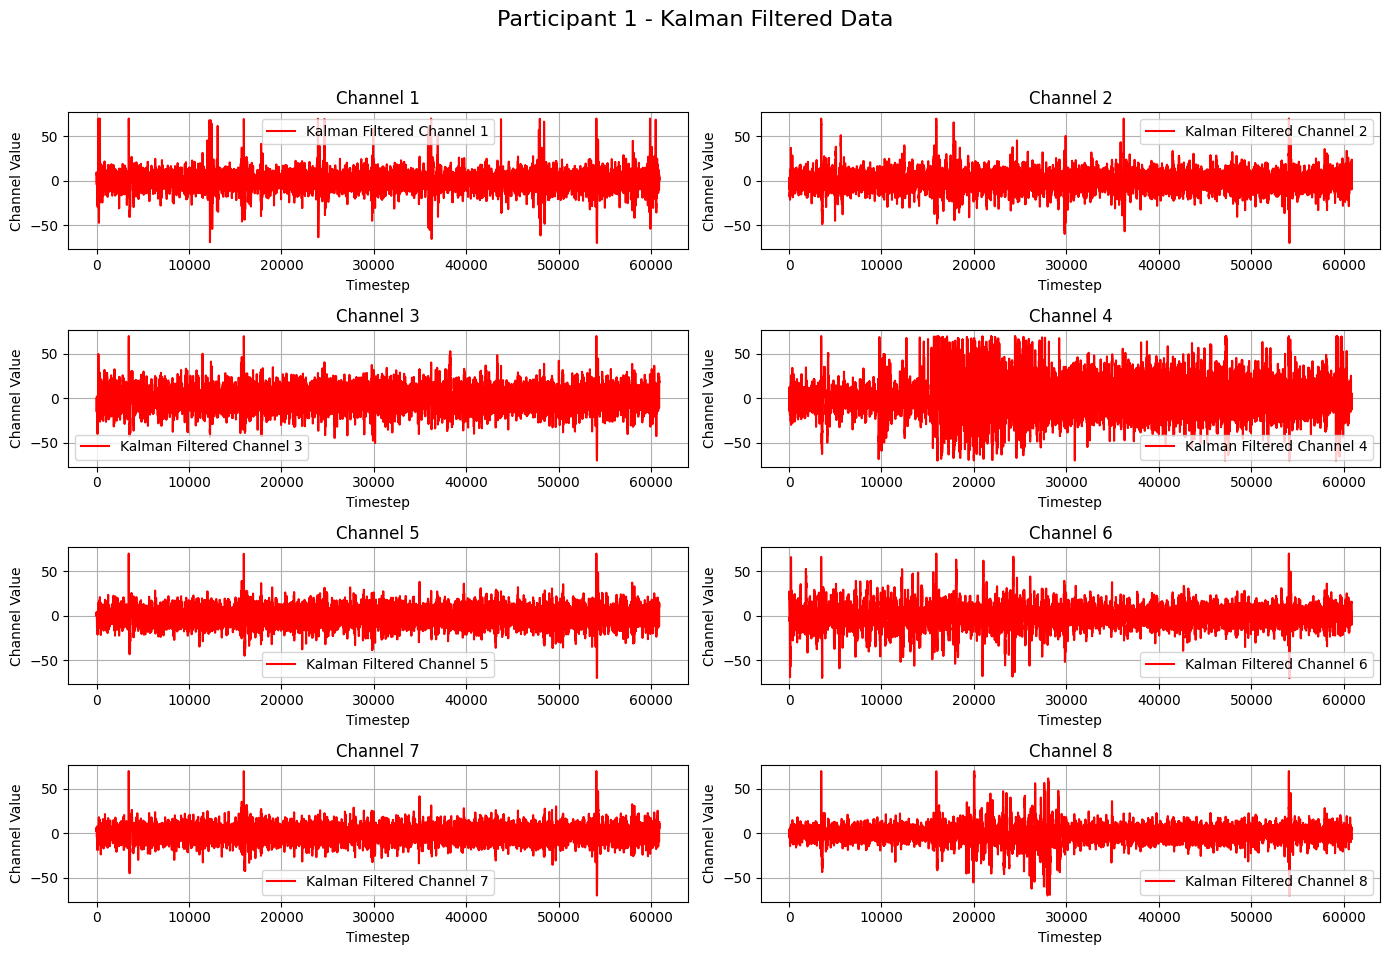

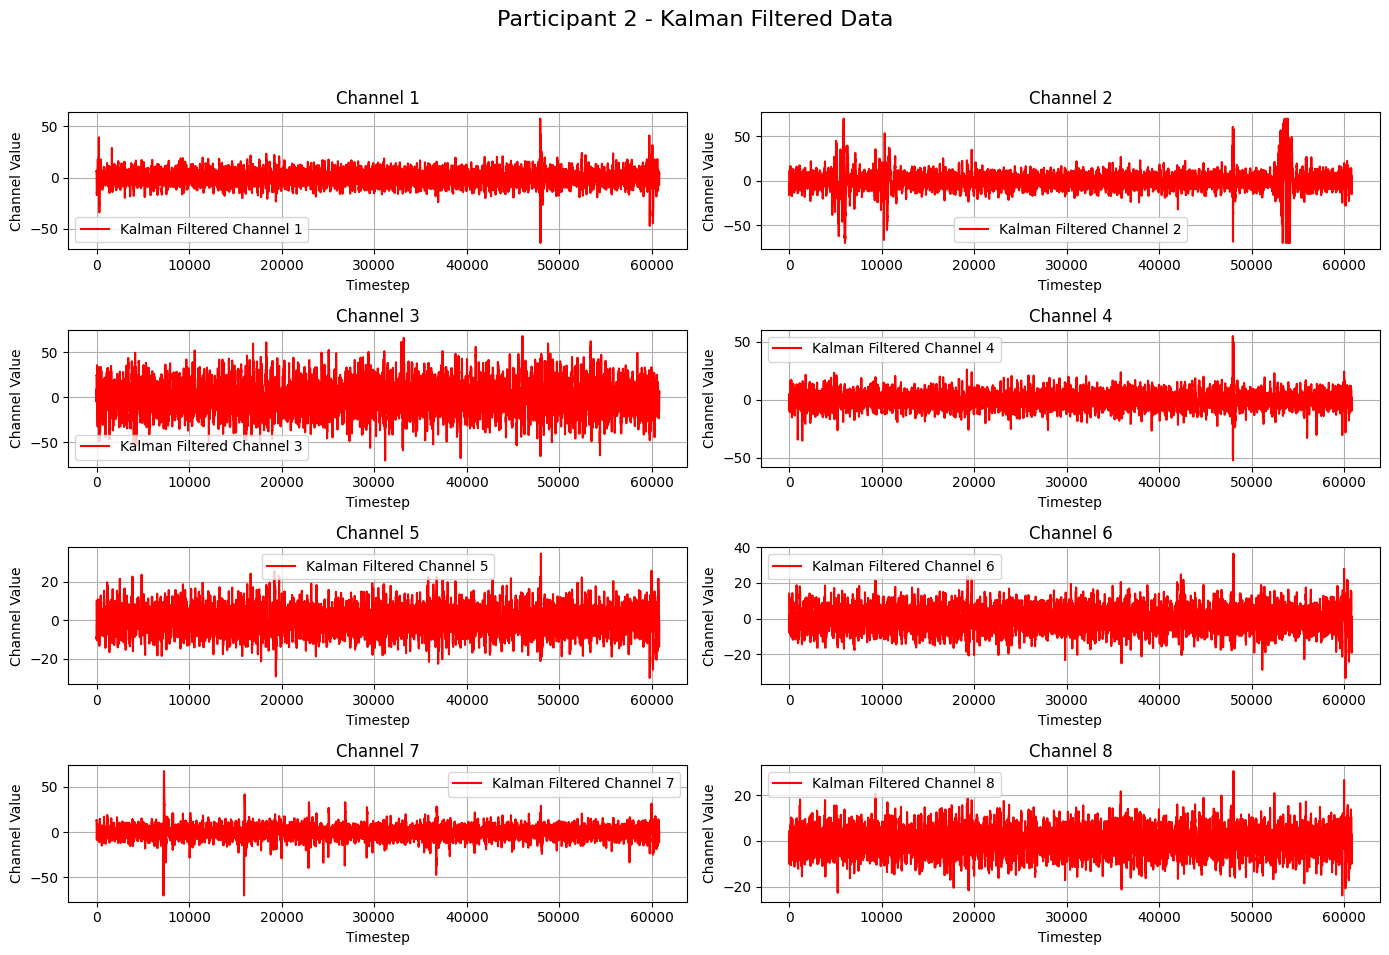

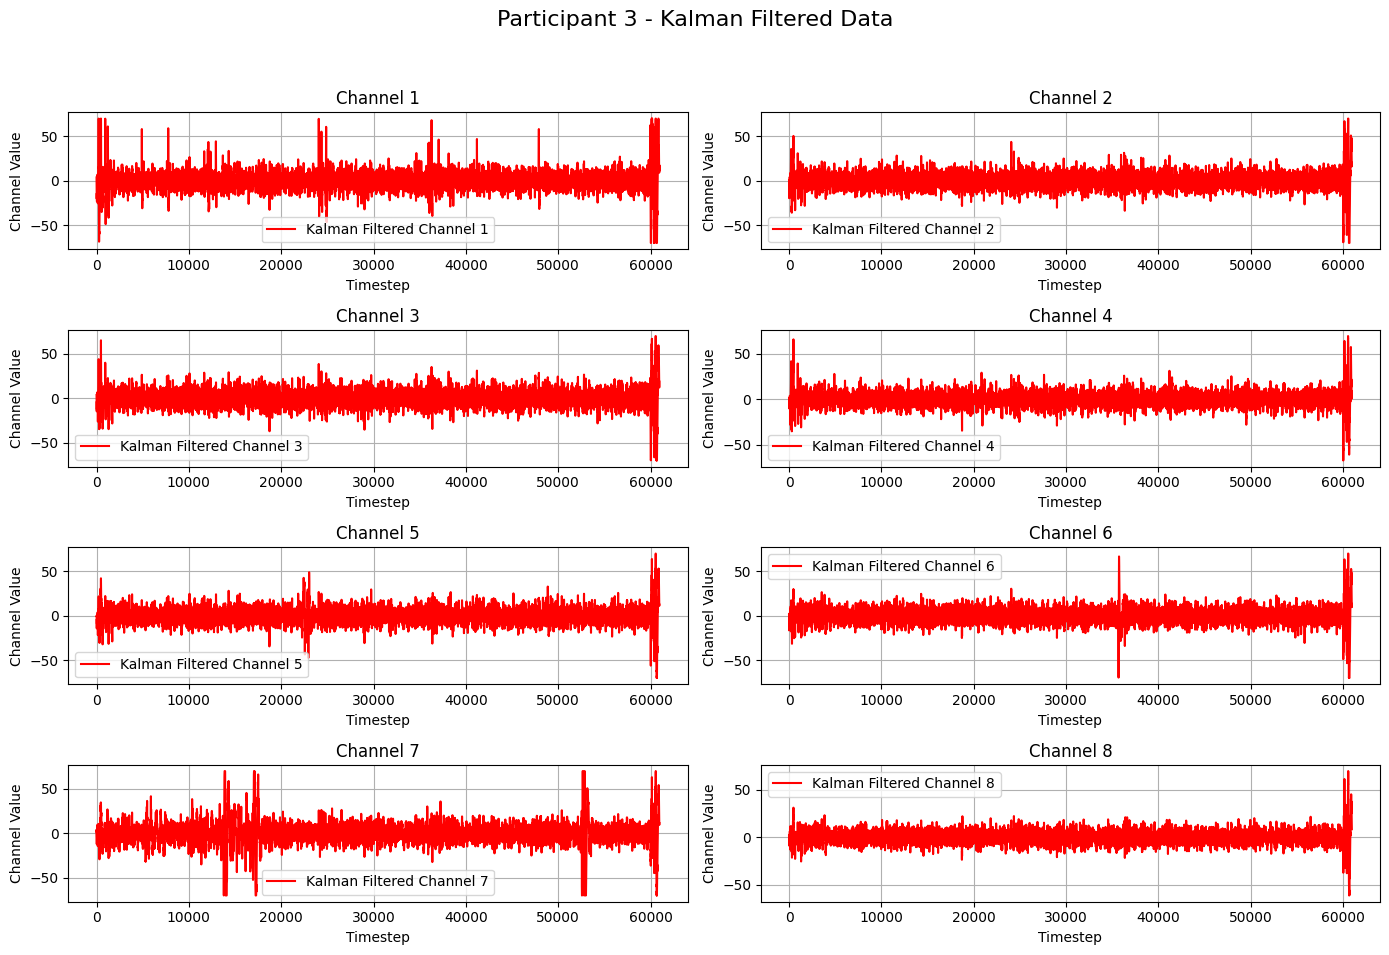

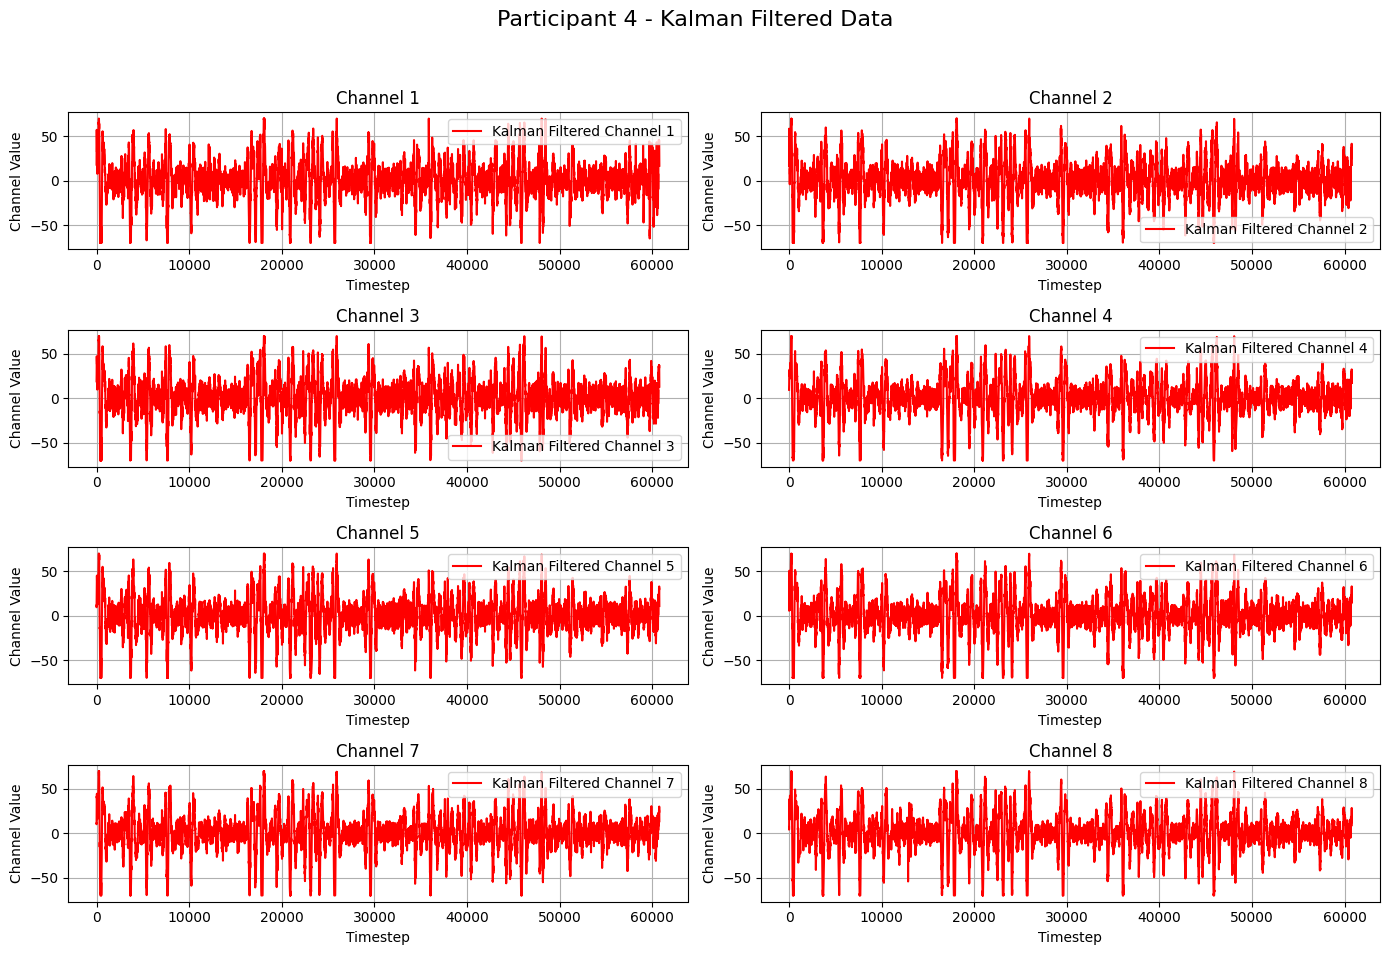

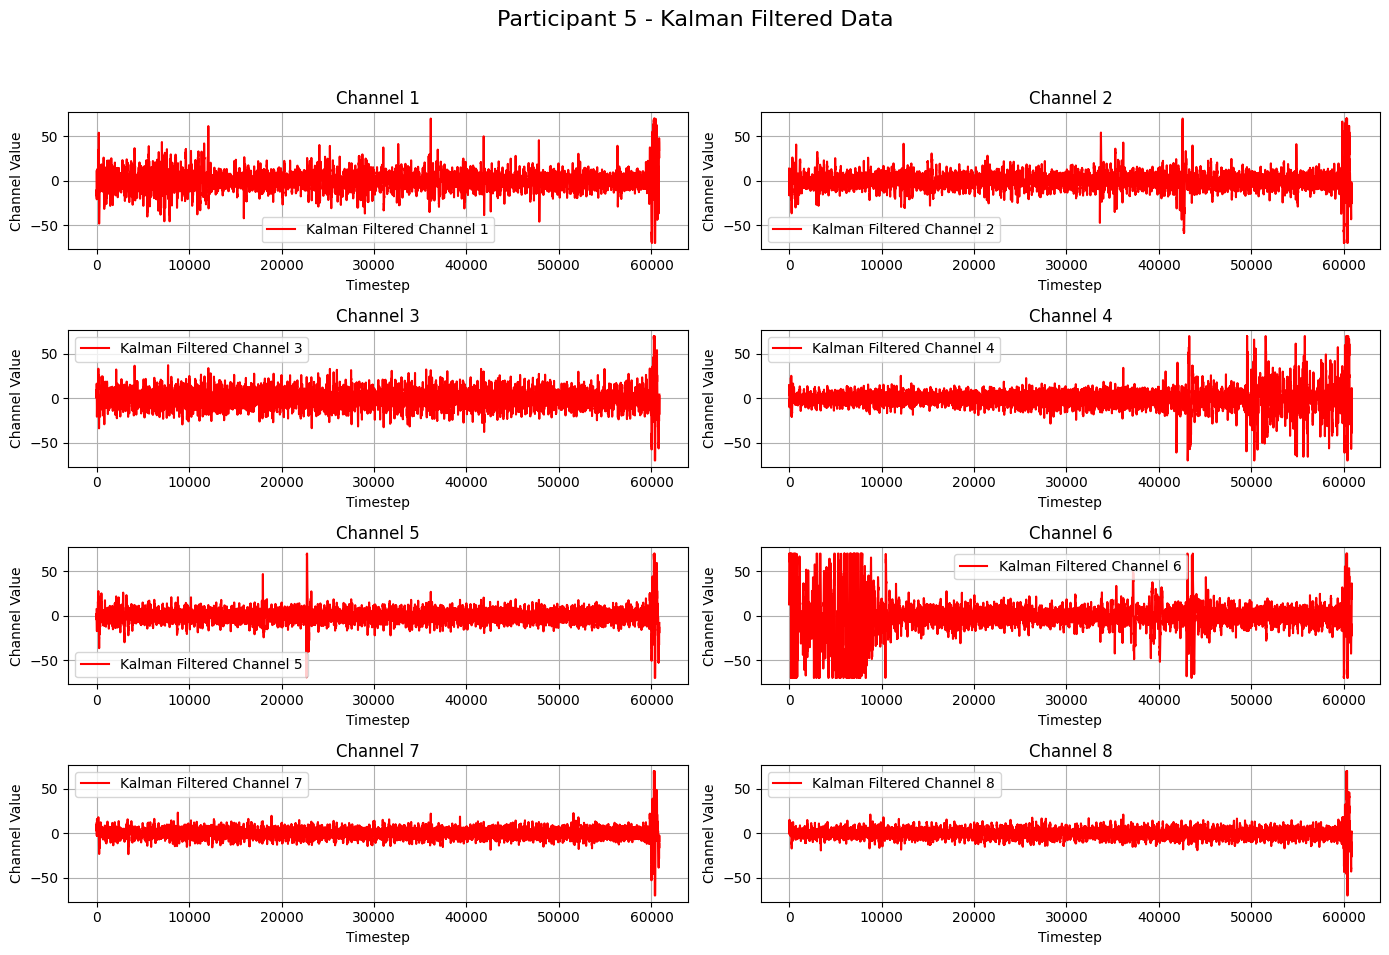

In [9]:
from pykalman import KalmanFilter

# Step 1: Define the Kalman filter function
def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    data = np.array(data)
    smoothed_data, _ = kf.smooth(data)
    return smoothed_data

# Step 2: Apply Kalman filter to the low-pass filtered data
df_kalman_filtered = df_filtered.copy()
for i in range(1, 9):  # Assuming channels 1 to 8
    df_kalman_filtered[f'channel_{i}'] = apply_kalman_filter(df_filtered[f'channel_{i}'])

# Step 3: Plotting - Kalman Filtered Data Only
grouped_kalman = df_kalman_filtered.groupby('participant_id')

# Iterate through each participant's data
for participant_id, kalman_group in grouped_kalman:
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))  # 4 rows and 2 columns for 8 channels
    fig.suptitle(f'Participant {participant_id} - Kalman Filtered Data', fontsize=16)

    # Plot each channel in a separate subplot
    for i in range(1, 9):
        ax = axs[(i-1)//2, (i-1)%2]  # Position in the 4x2 grid

        # Kalman filtered data in red
        ax.plot(kalman_group['timestep'], kalman_group[f'channel_{i}'], label=f'Kalman Filtered Channel {i}', color='red')

        ax.set_title(f'Channel {i}')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Channel Value')
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for the title
    plt.show()


In [16]:

kalman_group.describe()

Unnamed: 0  participant_id      timestep     channel_1     channel_2  \
count  60855.000000         60855.0  60855.000000  60855.000000  60855.000000   
mean   30427.000000             5.0  30428.000000      0.086633      0.043550   
std    17567.469653             0.0  17567.469653     11.244888     10.400451   
min        0.000000             5.0      1.000000    -70.000000    -70.000000   
25%    15213.500000             5.0  15214.500000     -5.847352     -5.179734   
50%    30427.000000             5.0  30428.000000      0.107570     -0.103529   
75%    45640.500000             5.0  45641.500000      5.919974      5.039997   
max    60854.000000             5.0  60855.000000     69.998820     69.999920   

          channel_3     channel_4     channel_5     channel_6     channel_7  \
count  60855.000000  60855.000000  60855.000000  60855.000000  60855.000000   
mean       0.016057      0.022325      0.039910      0.208211      0.043655   
std       10.382905     11.929150      8.303061     20.639693      6.550546   
min      -70.000000    -70.000000    -70.000000    -70.000000    -70.000000   
25%       -6.334252     -4.832270     -4.203358     -6.685745     -3.315630   
50%       -0.156675      0.119895      0.023398      0.118522      0.002249   
75%        6.145394      4.950599      4.328470      6.784095      3.362706   
max       69.999663     69.999858     69.999640     70.000000     69.999789   

          channel_8       trigger  
count  60855.000000  60855.000000  
mean       0.025034     -0.014789  
std        6.565761      0.139645  
min      -70.000000     -1.000000  
25%       -3.398774      0.000000  
50%        0.018414      0.000000  
75%        3.415717      0.000000  
max       70.000000      1.000000

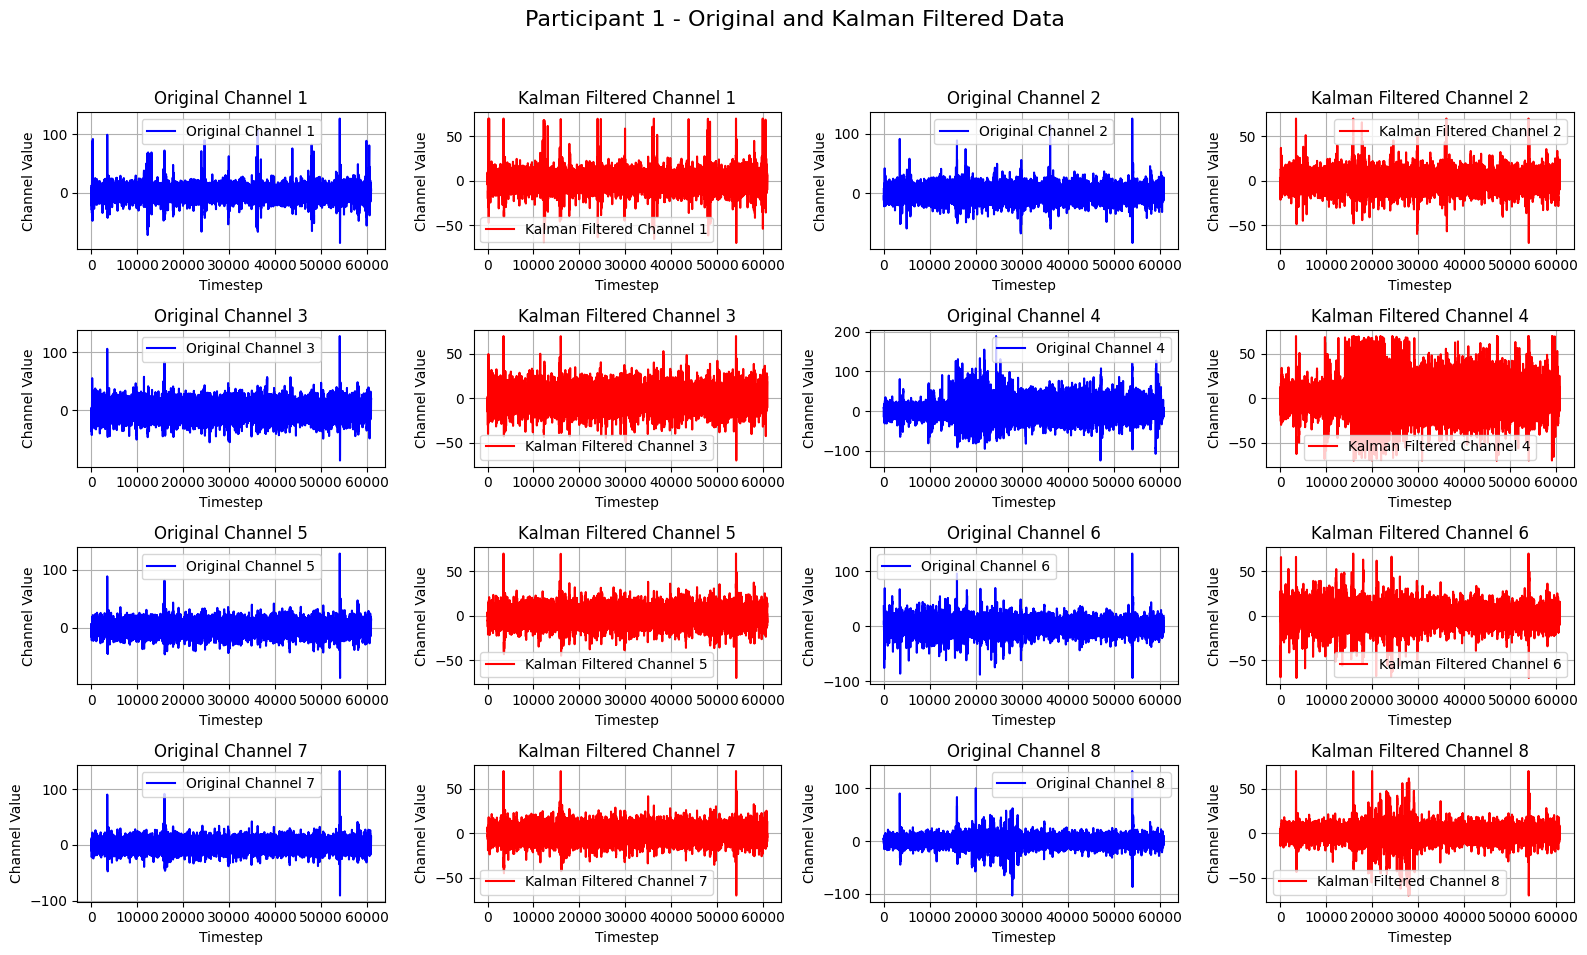

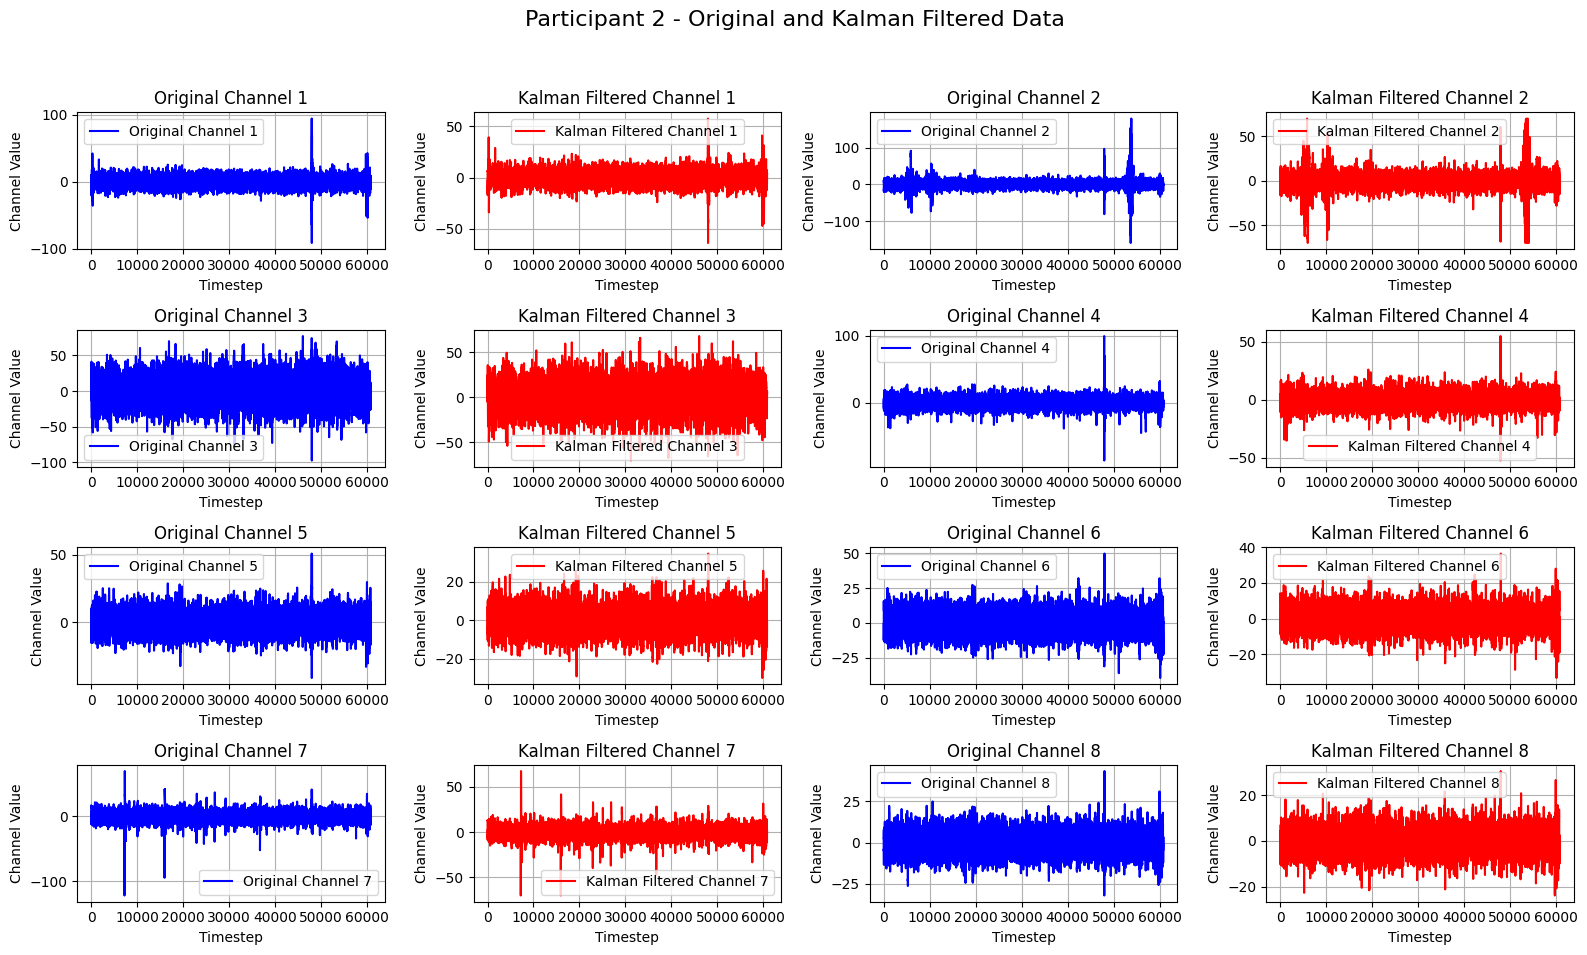

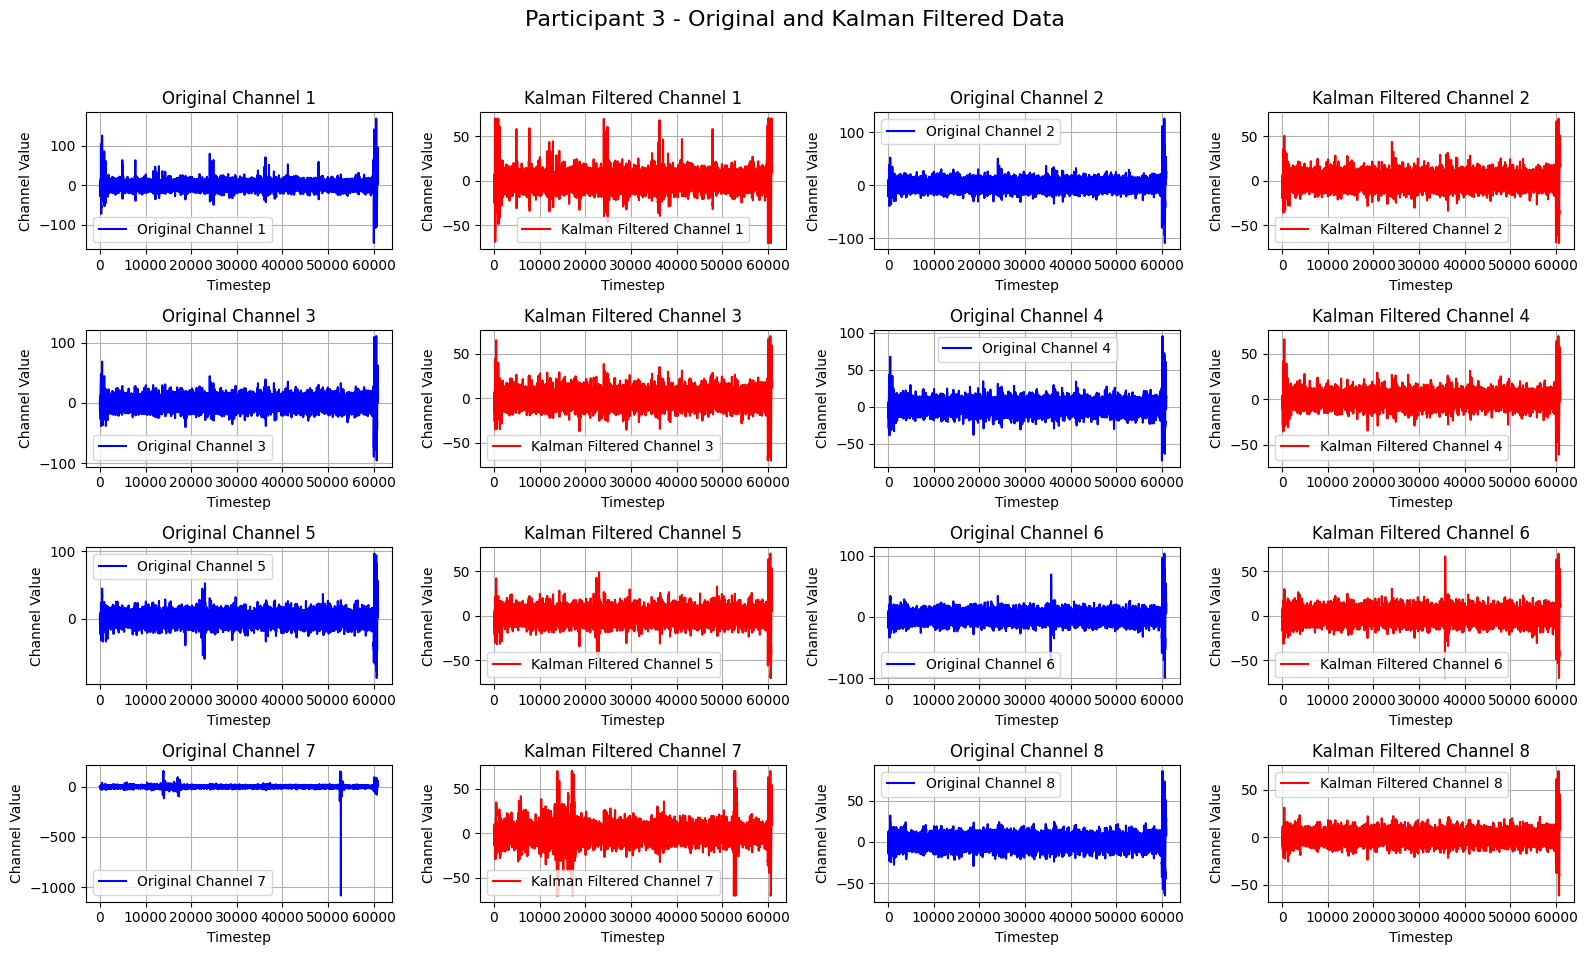

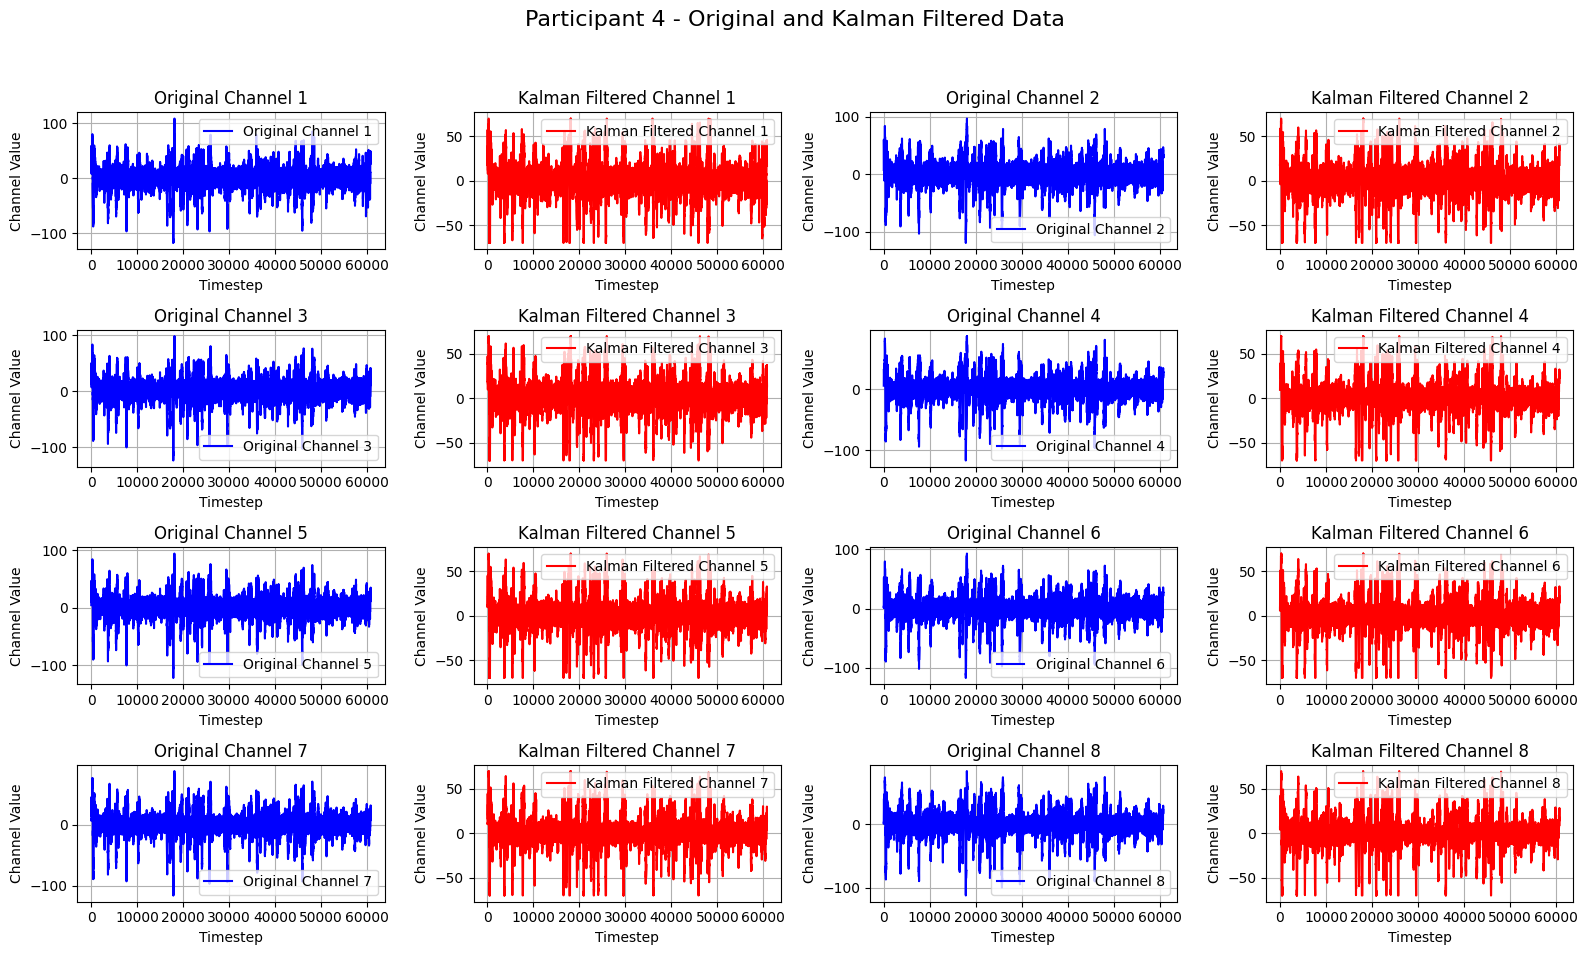

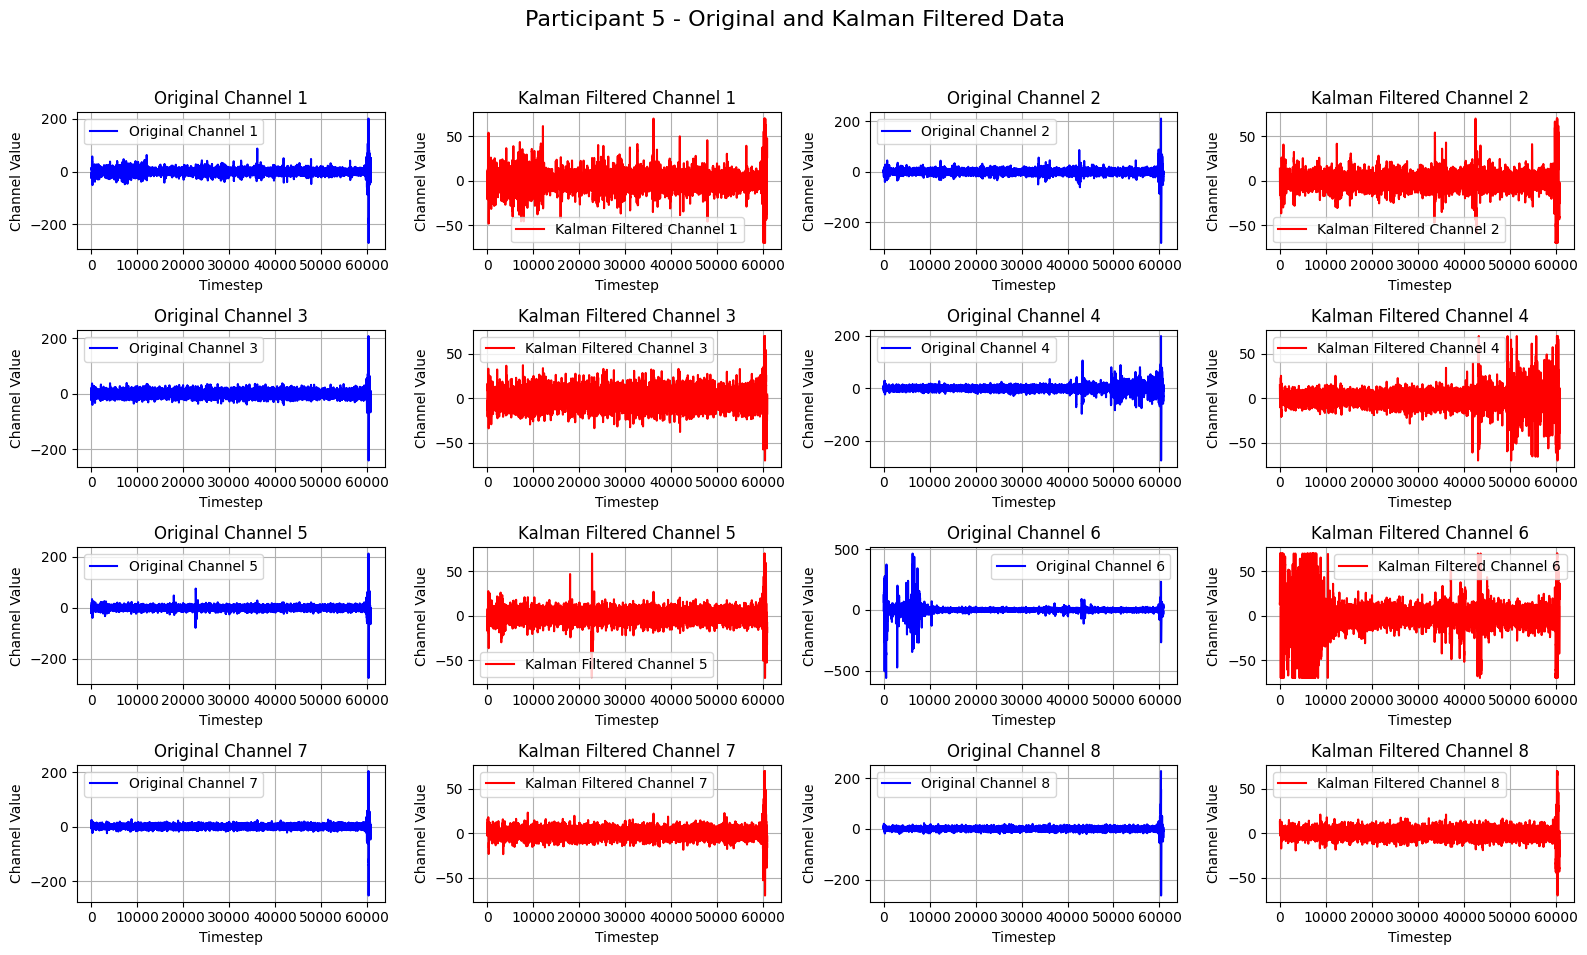

In [15]:
# Step 1: Plotting - Original and Kalman Filtered Data Side by Side
grouped_original = df.groupby('participant_id')
grouped_kalman = df_kalman_filtered.groupby('participant_id')

# Iterate through each participant's data
for (participant_id, original_group), (_, kalman_group) in zip(grouped_original, grouped_kalman):
    fig, axs = plt.subplots(4, 4, figsize=(16, 10))  # 4 rows and 4 columns (2 for each channel: original and Kalman)
    fig.suptitle(f'Participant {participant_id} - Original and Kalman Filtered Data', fontsize=16)

    # Plot each channel in separate subplots (side by side: original on the left, Kalman on the right)
    for i in range(1, 9):
        # Left subplot: Original data
        ax_original = axs[(i-1)//2, (i-1)%2 * 2]  # Position in the 4x4 grid (left side)
        ax_original.plot(original_group['timestep'], original_group[f'channel_{i}'], label=f'Original Channel {i}', color='blue')
        ax_original.set_title(f'Original Channel {i}')
        ax_original.set_xlabel('Timestep')
        ax_original.set_ylabel('Channel Value')
        ax_original.grid(True)
        ax_original.legend()

        # Right subplot: Kalman filtered data
        ax_kalman = axs[(i-1)//2, (i-1)%2 * 2 + 1]  # Position in the 4x4 grid (right side)
        ax_kalman.plot(kalman_group['timestep'], kalman_group[f'channel_{i}'], label=f'Kalman Filtered Channel {i}', color='red')
        ax_kalman.set_title(f'Kalman Filtered Channel {i}')
        ax_kalman.set_xlabel('Timestep')
        ax_kalman.set_ylabel('Channel Value')
        ax_kalman.grid(True)
        ax_kalman.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for the title
    plt.show()
